In [168]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)

### Read processed files and create big matrix with all rows

In [169]:
setwd("~/Downloads/")
df_all <- NA
count <- 1
for (file in list.files(pattern = "*log")) {
    print(file)
    if (is.null(df_all)) {
        df_all <- data.frame(read.csv(file, sep=",", header = F))
    } else {
        df_all <- rbind(df_all, data.frame(read.csv(file, sep=",", header = F)))
    }
    if (count==40) {
        break
    }
    count <- count + 1
}
df_all <- df_all[complete.cases(df_all),]

[1] "data0.log"
[1] "data1.log"
[1] "data2.log"
[1] "data3.log"
[1] "data4.log"
[1] "data5.log"
[1] "data6.log"
[1] "data7.log"


### Experiment parameters

In [170]:
# Resolution for target frequency [0-100]
input_resolution <- 0.5
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [176]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 3
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)


ind_data <- seq(from=1,to=rows)

# Reshaoe dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:204])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 204:((204 * 2) - 1)])
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (204 * 2):((204 * 3) - 1)])
Y <- to_categorical(df_all[ind_data, 613:613], num_classes)

dim(X)
dim(Y)

[1] 71105   204     3

[1] 71105   162

In [177]:
ind_remove_no_target <- which(apply(Y,2,sum)==0)
paste0("Remiving ",length(ind_remove_no_target)," rows with NO target")

X <- X[-ind_remove_no_target,,]
Y <- Y[-ind_remove_no_target,]

dim(X)
dim(Y)

[1] "Remiving 140 rows with NO target"

[1] 70965   204     3

[1] 70965   162

In [178]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [179]:
# Split train/test
smp_size <- floor(0.75 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 53223   204     3

[1] 53223   162

[1] 17742   204     3

[1] 17742   162

### EDA of data

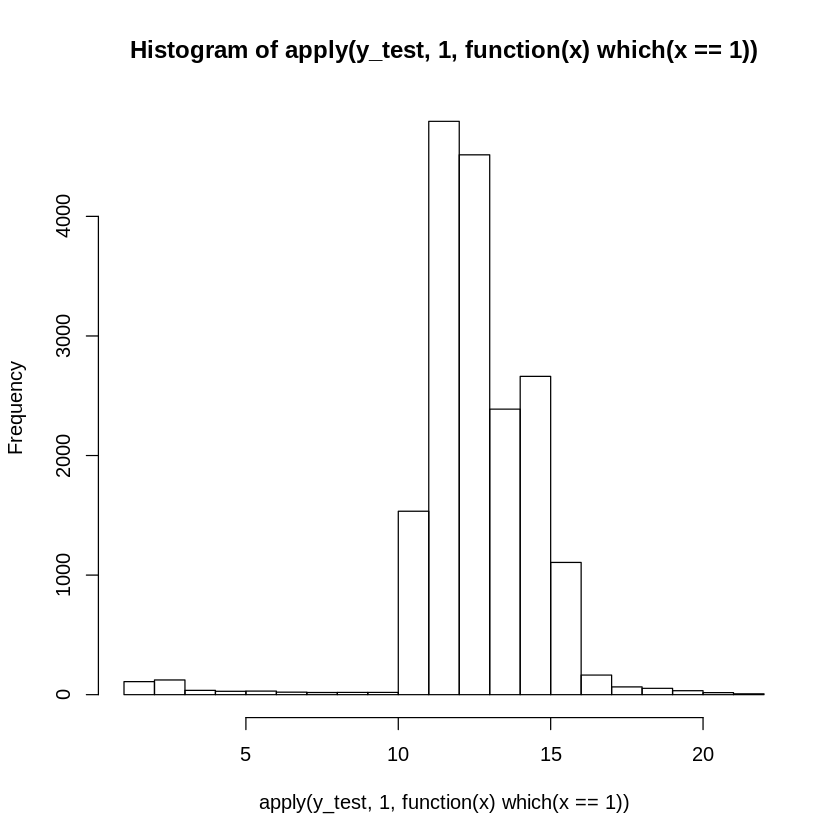

In [180]:
hist(apply(y_test,1,function(x) which(x==1)))

### NN train

In [133]:
top_12_categorical_accuracy <-
  custom_metric("rec_at_12", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 12)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })


# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_12_categorical_accuracy
        )
)
summary(model) # Plot summary

# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 8000,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2
  )

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_11 (SeparableConv1 (None, 200, 8)                  593         
________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D)     (None, 100, 8)                  0           
________________________________________________________________________________
dropout_11 (Dropout)                (None, 100, 8)                  0           
________________________________________________________________________________
batch_normalization_11 (BatchNormal (None, 100, 8)                  32          
________________________________________________________________________________
separable_conv1d_12 (SeparableConv1 (None, 96, 8)                   1568        
________________________________________________________________________________
max_pooling1d_12 (MaxPooling

In [134]:
#save_model_hdf5(model, paste0("~/Downloads/model_dnu",".h5"))
evaluate(model, x_test, y_test)

$loss
[1] 1.169693

$acc
[1] 0.6044505

$rec_at_2
[1] 0.8169846

$rec_at_4
[1] 0.9626097

$recat_6
[1] 0.9915229

$rec_at_12
[1] 0.9977293

In [77]:
plot(history) +
  theme_bw()

ERROR: Error in .External2(C_savehistory, file): no history available to save


### Confusion matrix

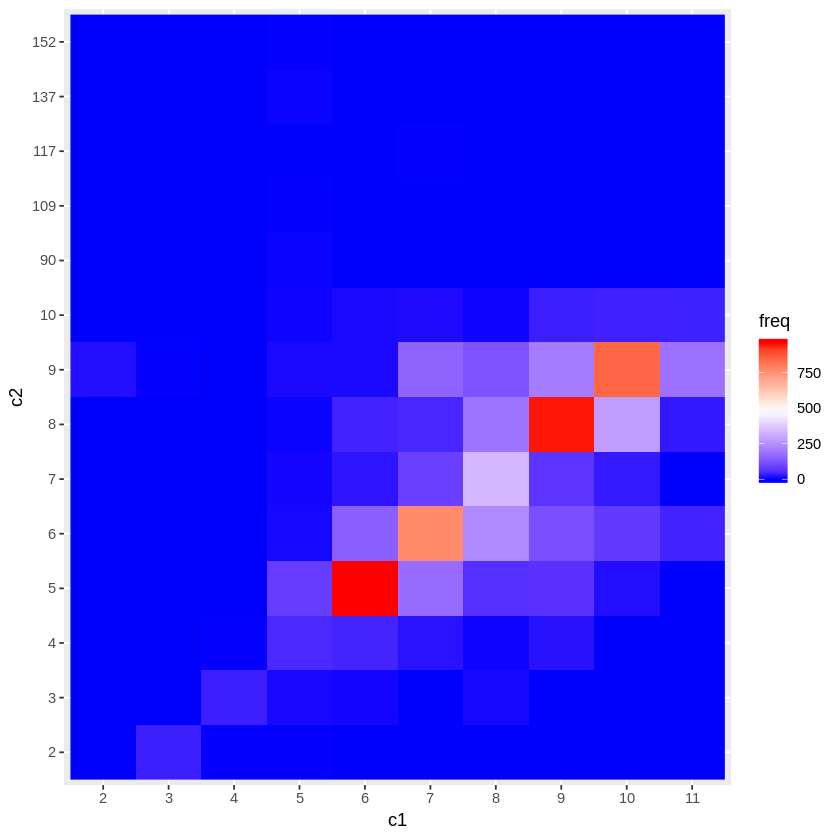

In [135]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

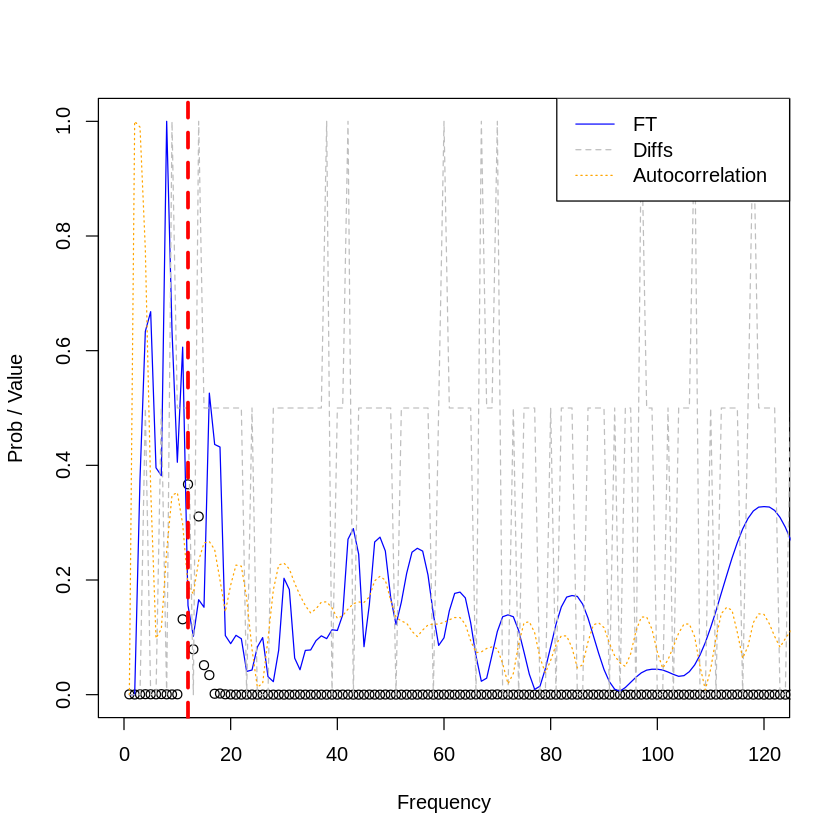

In [82]:
select_test <- 500

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)

lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)